# Dataset Statistics

## Imports

In [ ]:
!pip3 install pickle5
!pip install transformers

from google.colab import drive
import pickle5 as pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import LongformerTokenizer, LongformerForSequenceClassification, Trainer, TrainingArguments

     |████████████████████████████████| 133kB 27.7MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219265 sha256=327e3ab5157a033df41f45b0f48dd78053872e3046ab19333c16e26a19895691
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5
     |████████████████████████████████| 2.3MB 31.8MB/s 
     |████████████████████████████████| 3.3MB 42.6MB/s 
     |████████████████████████████████| 901kB 36.9MB/s 


In [ ]:
def save_as_pickle(obj, filename):
    """
    save an object in a pickle file dump
    :param obj: object to dump
    :param filename: target file
    :return:
    """
    directory = os.path.dirname(filename)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    with open(filename, 'wb') as file:
        pickle.dump(obj, file, protocol=pickle.HIGHEST_PROTOCOL)


def load_pickle(filename):
    """
    load an object from a given pickle file
    :param filename: source file
    :return: loaded object
    """
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [ ]:
drive.mount('/content/drive', force_remount=True)  # use force_remount=True param after upload of new data

# file and folder names
#ir_project_drive_folder = "Master/2 - FSS 2021/Information Retrieval/IR Projekt"  # TODO: geht das für alle?
ir_project_drive_folder = "IR Projekt"  # TODO: geht das für alle?
full_ir_project_drive_folder = "/content/drive/My Drive/{}/data/wikipedia".format(ir_project_drive_folder)

# full_ir_project_drive_folder = '../data/wikipedia'
raw_folder = full_ir_project_drive_folder + '/raw'
preprocessed_folder = full_ir_project_drive_folder + '/no-pron/preprocessed'

# raw qa filenames
qa_wikipedia_verified_dev_filename = raw_folder + '/qa/verified-wikipedia-dev.json'
qa_wikipedia_dev_filename = raw_folder + '/qa/wikipedia-dev.json'
qa_wikipedia_test_without_answers_filename = raw_folder + '/qa/wikipedia-test-without-answers.json'
qa_wikipedia_train_filename = raw_folder + '/qa/wikipedia-train.json'

# preprocessed evidence files
wikipedia_evidence_file = raw_folder + '/wikipedia_evidence_dict.pkl'
preprocessed_wikipedia_evidence_file = preprocessed_folder + '/preprocessed_wikipedia_evidence_dict.pkl'

# preprocessed qa files
preprocessed_qa_wikipedia_verified_dev_filename = preprocessed_folder + '/qa/verified-wikipedia-dev.pkl'
preprocessed_qa_wikipedia_dev_filename = preprocessed_folder + '/qa/wikipedia-dev.pkl'
preprocessed_qa_wikipedia_test_without_answers_filename = preprocessed_folder + '/qa/wikipedia-test-without-answers.pkl'
preprocessed_qa_wikipedia_train_filename = preprocessed_folder + '/qa/wikipedia-train.pkl'

## neural retrieval
neuralIR_wiki_train_file = preprocessed_folder + '/neural_Reranking/train.pkl'
neuralIR_wiki_dev_ver_file = preprocessed_folder + '/neural_Reranking/dev_verified.pkl'

Mounted at /content/drive


In [ ]:
documents_dict = load_pickle(wikipedia_evidence_file)
preprocessed_qa_wikipedia_train = load_pickle(preprocessed_qa_wikipedia_train_filename)
preprocessed_qa_wikipedia_dev = load_pickle(preprocessed_qa_wikipedia_dev_filename)
preprocessed_qa_wikipedia_verified_dev = load_pickle(preprocessed_qa_wikipedia_verified_dev_filename)
preprocessed_qa_wikipedia_test_without_answers = load_pickle(preprocessed_qa_wikipedia_test_without_answers_filename)

In [ ]:
print(len(documents_dict))
print(len(preprocessed_qa_wikipedia_train))
print(len(preprocessed_qa_wikipedia_dev))
print(len(preprocessed_qa_wikipedia_verified_dev))
print(len(preprocessed_qa_wikipedia_test_without_answers))
print(len(preprocessed_qa_wikipedia_train)+len(preprocessed_qa_wikipedia_dev)+len(preprocessed_qa_wikipedia_test_without_answers))

73930
61888
7993
318
7701
77582


## Document Stats

In [ ]:
lengths = {}
raw_lengths = []
for i, (doc_name, doc_text) in enumerate(documents_dict.items()):
  if i % 5000 == 0:
    print(i)
  doc_length = len(doc_text.split())
  raw_lengths.append(doc_length)
  if doc_length not in lengths:
    lengths[doc_length] = 1
  else:
    lengths[doc_length] += 1

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000


In [ ]:
lengths_sorted = list(sorted([(length, occurences)for length, occurences in lengths.items()], key=lambda length_pair: length_pair[0]))

In [ ]:
x = [length_pair[0] for length_pair in lengths_sorted]
y = [length_pair[1] for length_pair in lengths_sorted]

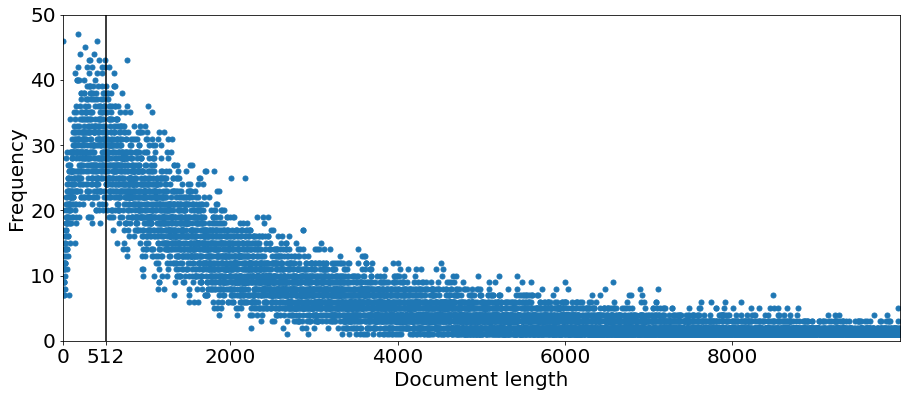

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(x, y, 'o', markersize=5)
ax.set_xlim(left=0, right=10000)
ax.set_ylim(top = 50, bottom=0)
ax.set_xticks([0, 512, 2000, 4000, 6000, 8000])
ax.set_xticklabels([0, 512, 2000, 4000, 6000, 8000])
ax.tick_params(axis='both', labelsize=20)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_xlabel("Document length")
ax.set_ylabel("Frequency")
ax.plot([512, 512], [0, 50], 'k-')
# ax.plot(z, color='black', label='Cosine wave')

plt.savefig('doc-length-distribution.png')
plt.show()

In [ ]:
smaller_512 = [raw_length for raw_length in raw_lengths if raw_length <= 512]
print(len(smaller_512))

[7223, 10167, 8327, 129, 2962, 438, 2196, 1876, 503, 1048]
14839


## QA Stats

In [ ]:
evidence_document_numbers = []
qa_pairs = 0
def calc_qa_stats(dataset):
  for qa_pair in dataset:
    evidence_document_numbers.append(len(qa_pair['EntityPages']))
    global qa_pairs
    qa_pairs += 1

calc_qa_stats(preprocessed_qa_wikipedia_train)
calc_qa_stats(preprocessed_qa_wikipedia_dev)
calc_qa_stats(preprocessed_qa_wikipedia_verified_dev)


In [ ]:
print(qa_pairs)
print(sum(evidence_document_numbers) / qa_pairs)

70199
1.7880026781008276
